# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


In [21]:
## Import Libraries
import numpy as np

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import torch.optim as optim

from torchvision import datasets, transforms


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import adjusted_rand_score, accuracy_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

# Used to save data into files
import pickle as pkl
import os

# Used to measure time
import time

In [13]:
## Import train and test dataset, scale them and convert them to data loaders

BATCH_SIZE = 64


train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False)

In [14]:
## Randomly select some images from the training and test dataset

subset_size = 10000

## set a seed for randperm
th.manual_seed(42)

idx = th.randperm(len(train_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

train_subset_loader = DataLoader(train_dataset, sampler=sampler)

idx = th.randperm(len(test_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

test_subset_loader = DataLoader(train_dataset, sampler=sampler)

del(idx)
del(sampler)

In [15]:
## Convert the images and their labels to numpy arrays and reshape them to vectors
labels_train = []
train_subset = []
for batch in train_subset_loader:
    data, labels = batch
    
    train_subset.append(data.numpy().reshape(1, -1))
    labels_train.append(labels.numpy())

train_subset_scaled = np.array(train_subset).reshape(subset_size, -1)
labels_train = np.array(labels_train)

In [16]:
test_subset = []
labels_test = []

for batch in test_subset_loader:
    data, labels = batch
    
    test_subset.append(data.numpy().reshape(1, -1))
    labels_test.append(labels.numpy())

test_subset_scaled = np.array(test_subset).reshape(subset_size, -1)
labels_test = np.array(labels_test)

In [17]:
# Creating dictionary of labels for better understanding
description = {0: "T-shirt/top", 
               1: "Trouser", 
               2: "Pullover", 
               3: "Dress", 
               4: "Coat", 
               5: "Sandal", 
               6: "Shirt", 
               7: "Sneaker", 
               8: "Bag", 
               9: "Ankle boot"}

ticks = list(description.keys())
tick_labels = list(description.values())

In [18]:
## Defining functions to save and load data from pickle files

def save_data(data, filename):
    if not os.path.exists(filename):
        with open(filename, "wb") as f:
            pkl.dump(data, f)

def load_data(filename):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            data = pkl.load(f)
    return data

T-shirt/top: 3.0
Trouser: 4.0
Pullover: 3.0
Dress: 4.0
Coat: 1.0
Sandal: 2.0
Shirt: 3.0
Sneaker: 3.0
Bag: 2.0
Ankle boot: 5.0


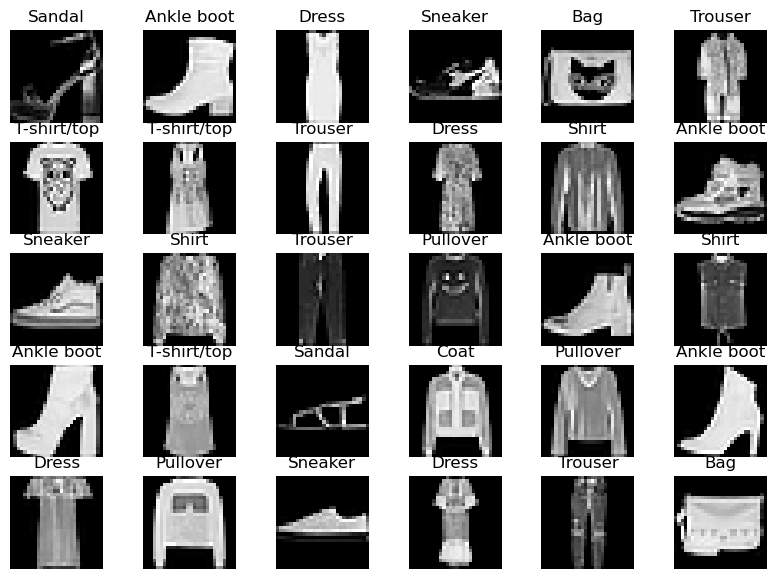

In [20]:
# Printing samples and checking labels
indices = np.random.choice(train_subset_scaled.shape[0], size=30, replace=False)


def print_img_index(indices, img_set, lab_set):
    counter = np.zeros(10)

    # Counting number of appearance of each label
    for i in range(len(indices)):
        label = lab_set[indices[i]]
        counter[label] += 1

    # Plotting the images with the labels as titles
    fig, axs = plt.subplots(5, 6, figsize=(10, 7))
    axs = axs.flatten()

    for i, idx in enumerate(indices):
        axs[i].imshow(
            img_set[idx].reshape(28, 28), cmap="gray"
        )  # Assuming images are 28x28 pixels
        axs[i].axis("off")  # Turn off axis labels for cleaner visualization
        # string = str(description[labels_subset[idx]])
        axs[i].set_title(description[lab_set[idx].item()])

    # Printing the counted amounts
    for j in range(10):
        print(f"{description[j]}: {counter[j]}")

print_img_index(indices, train_subset_scaled, labels_train)

## Exercise 1

In [27]:
# Choose the color map for the plots
colors_rgb = [(33,240,182), (21,122,72), (155,209,198), (16,85,138), (172,139,248), (133,22,87), (197,81,220), (56,181,252), (18,85,211), (171,230,91)]
colors_rgb_normalized = colors_rgb_normalized = np.array(colors_rgb) / 255.0
cmap = ListedColormap(colors_rgb_normalized)

In [28]:
## Perform linear PCA

model = PCA(n_components = 3)
data_pca_linear = model.fit_transform(train_subset_scaled)

del(model)

Text(0, 0.5, 'Principal Component 2')

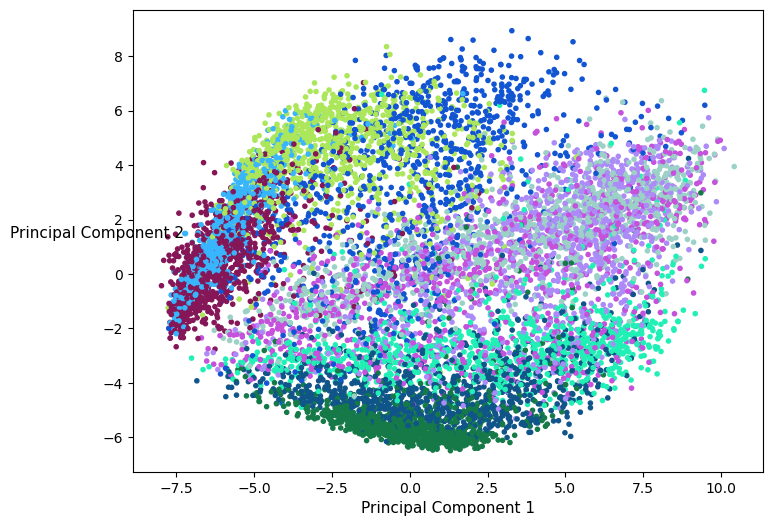

In [37]:
# Plot the first two principal components

fig = plt.figure(figsize=(9, 6))
plt.subplots_adjust(left=0.2)
p = plt.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], c = labels_train, marker='.', cmap = cmap)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11, rotation=0)


# Uncomment to plot the colorbar
# cb = plt.colorbar(p)
# cb.set_ticks(ticks)
# cb.set_ticklabels(tick_labels)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

# plt.savefig("Report/pca_linear_2comps.png")

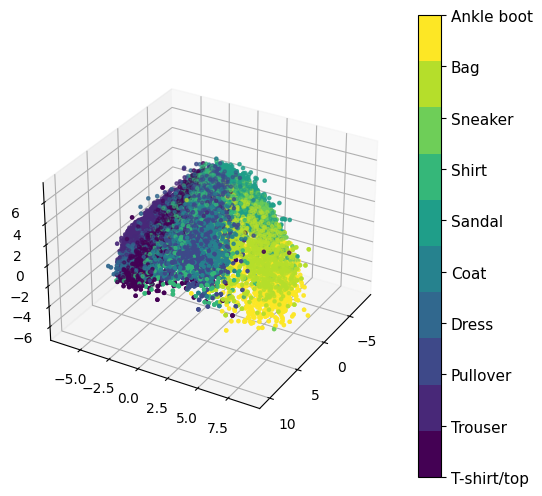

In [11]:
# Plot the first two principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], data_pca_linear[:, 2], c = labels_train, marker='.', cmap=cmap)
ax.view_init(elev=30, azim=30)


# Uncomment to show colorbar
cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
# cb.ax.set_title('Class', fontsize=11)
del(cb)

del(fig)
del(ax)
del(p)


# plt.savefig("Report/pca_linear_3comps.png")

#### Comment
The data does not seem to be well separated, so finding the right hyperplane for classification will be hard.

### 1.2: Perform kernel PCA

In [12]:
# Perform kernel pca using the RBF kernel
    
kernel_pca = KernelPCA(kernel="rbf", n_components = 3)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

In [31]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_train, marker='.', cmap=cmap)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

del(p)
del(fig)
# plt.savefig("Report/pca_rbf_2comps.png")

NameError: name 'data_pca_rbf' is not defined

<Figure size 600x600 with 0 Axes>

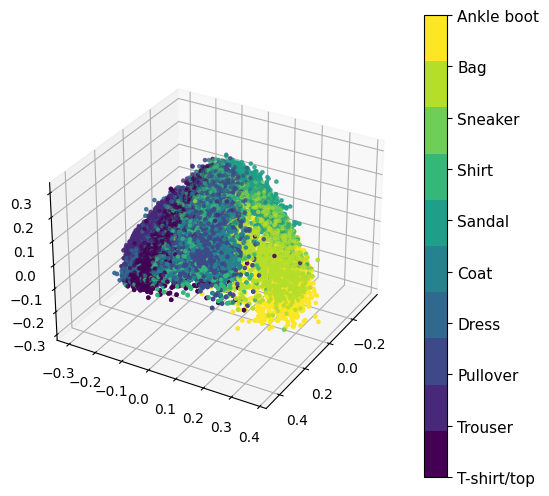

In [14]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], data_pca_rbf[:, 2], c = labels_train, marker='.', cmap=cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
del(cb)

ax.view_init(elev=30, azim=30)

del(fig)
del(ax)
del(p)

# plt.savefig("Report/pca_rbf_3comps.png")

### Perform parameter tuning

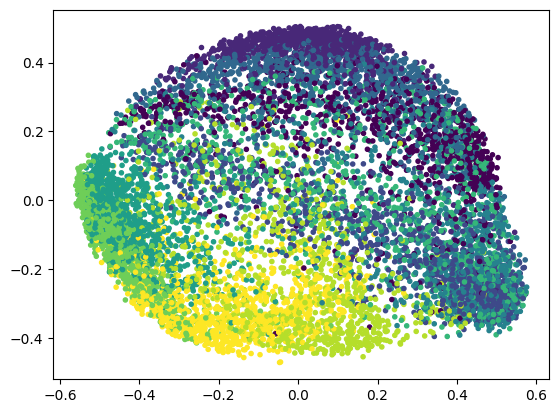

In [15]:
kernel_pca = KernelPCA(kernel = "rbf", n_components = 3, gamma = 5 / 784)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_train, marker='.', cmap=cmap)

In [16]:
# Perform kernel pca using the RBF kernel, tune gamma to separate clusters
    
gamma = np.array([(1/10)*(1/784), 1/784, 10 * (1/784)])

data_pca_rbf = np.ndarray((10000, 3, len(gamma)))

for i in range(len(gamma)):
    kernel_pca = KernelPCA(kernel = "rbf", n_components = 3, gamma = gamma[i])
    data_pca_rbf[:, :, i] = kernel_pca.fit_transform(train_subset_scaled)

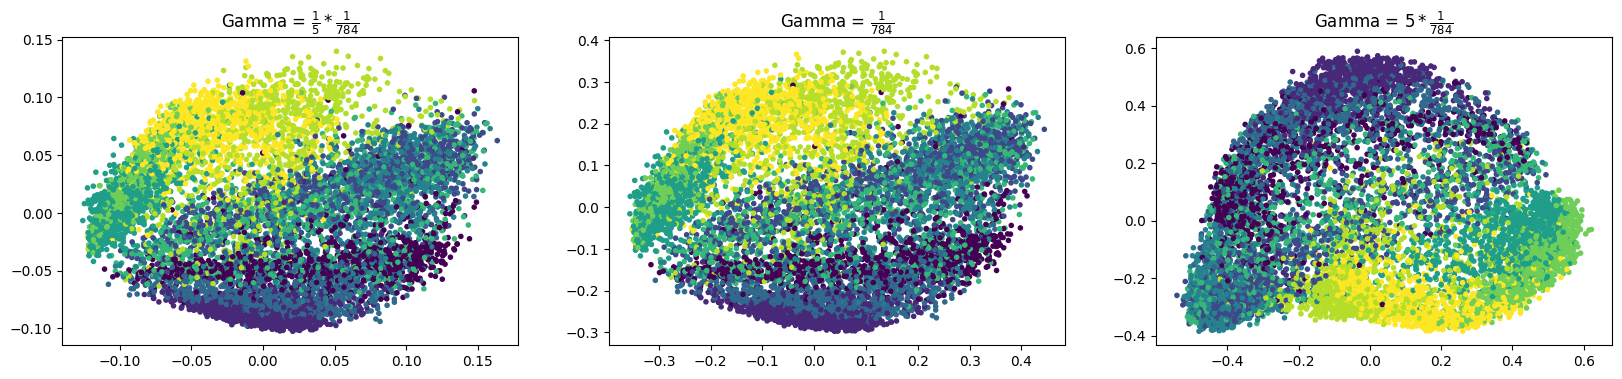

In [17]:
# scatterplot for different gammas

gammas = ["$\\frac{1}{5} * \\frac{1}{784}$", "$\\frac{1}{784}$", "$5 * \\frac{1}{784}$"]
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

for i, ax in enumerate(axs.flat):
    p = ax.scatter(data_pca_rbf[:, 0, i], data_pca_rbf[:, 1, i], c = labels_train, marker='.', cmap=cmap)
    ax.set_title('Gamma = ' + gammas[i])

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)

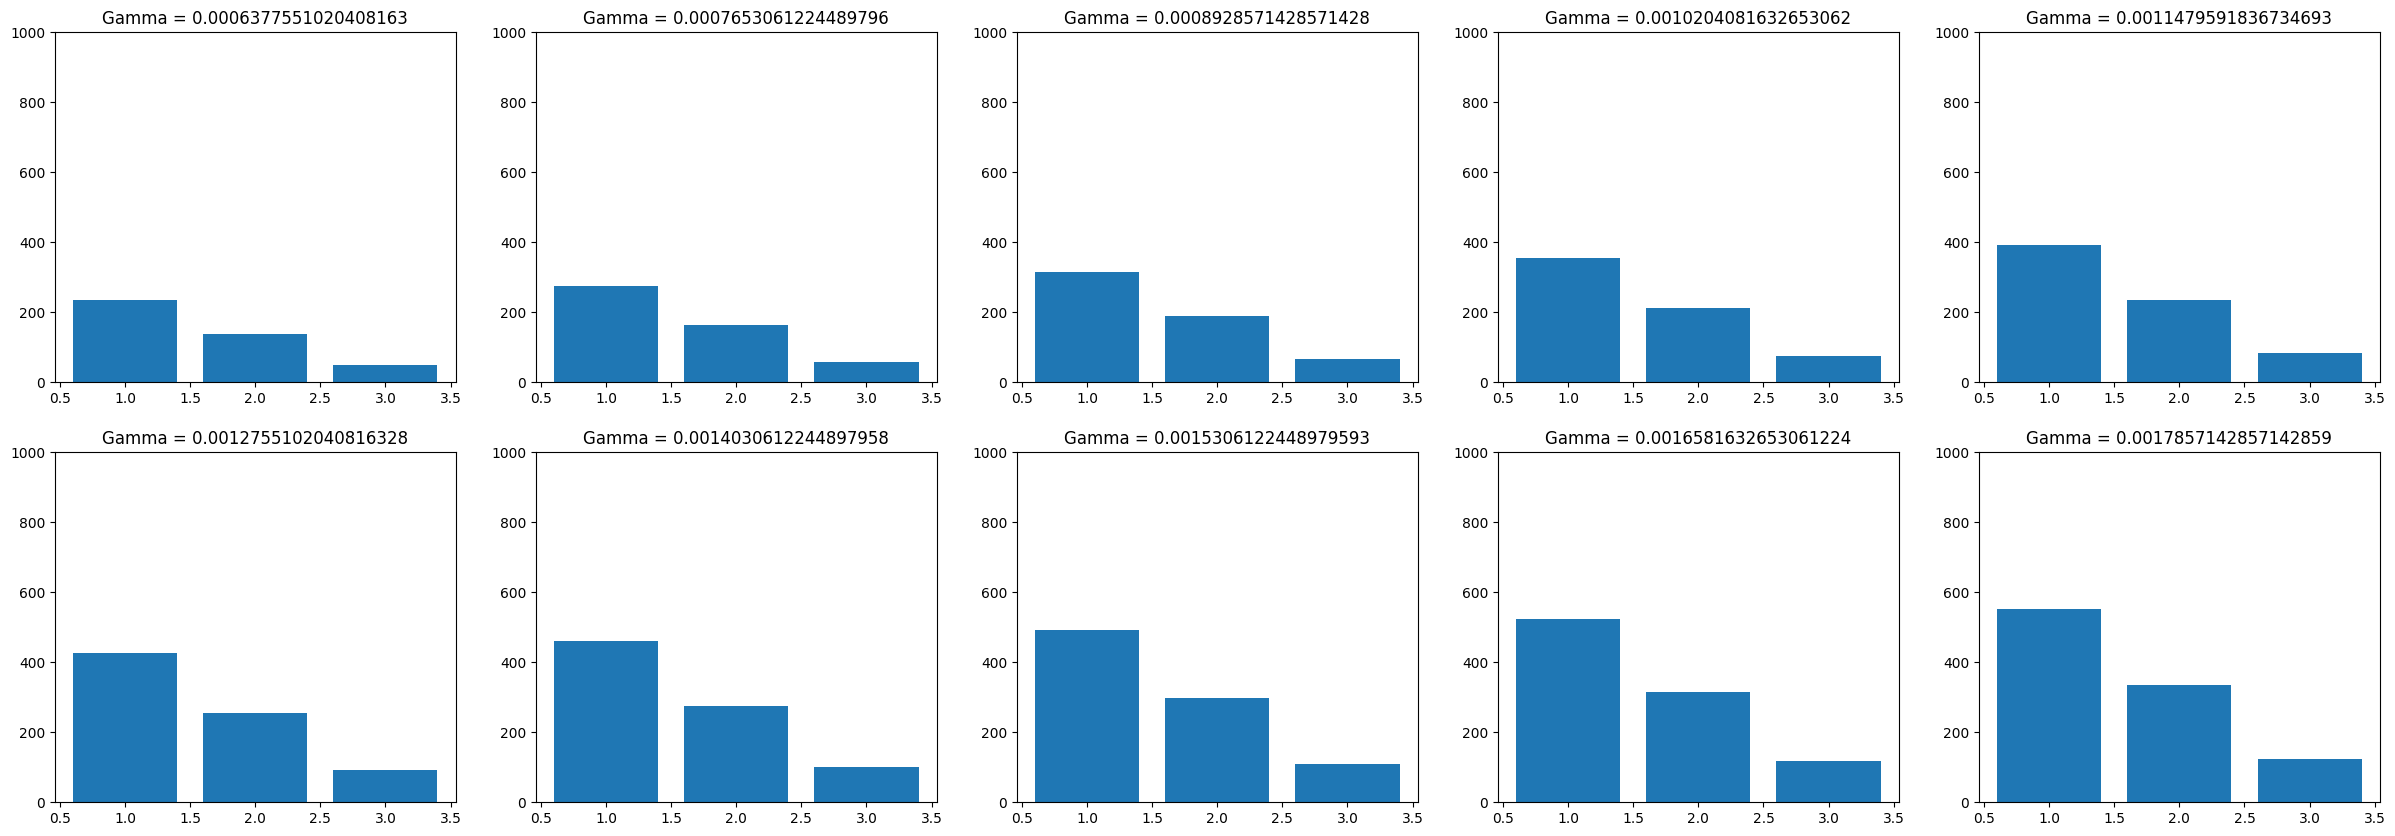

In [18]:
## Choose the range of the parameter gamma
gammas = np.arange(1/784 - 5 * (1/784) * (1/10), 1/784 + 5 * (1/784) * (1/10), (1/784) * (1/10))

## Extract eigenvalues
n_components = 3
eigenvalues_rbf = np.empty((len(gammas), n_components))

for i in range(len(gammas)):
    kernel_pca = KernelPCA(kernel="rbf", n_components = n_components, gamma = gammas[i])
    eigenvalues_rbf[i] = kernel_pca.fit(train_subset_scaled).eigenvalues_



fig, axs = plt.subplots(2, 5, figsize=(30, 10))
# Create 10 random plots
for i, ax in enumerate(axs.flat):
    x = np.arange(1, len(eigenvalues_rbf[i, :]) + 1, 1)
    # Plot the data on the corresponding axis
    ax.bar(x, eigenvalues_rbf[i, :])
    ax.set_ylim(0, 1000)
    # ax.set_xlabel('Component')
    # ax.set_ylabel('Eigenvalue')
    ax.set_title('Gamma = ' + str(gammas[i]))

### 1.3 Perform kPCA using another kernel

In [19]:
# Try kernel poly

kernel_pca = KernelPCA(kernel = "poly", n_components = 3)

data_pca_poly = kernel_pca.fit_transform(train_subset_scaled)

Text(0, 0.5, 'Principal Component 2')

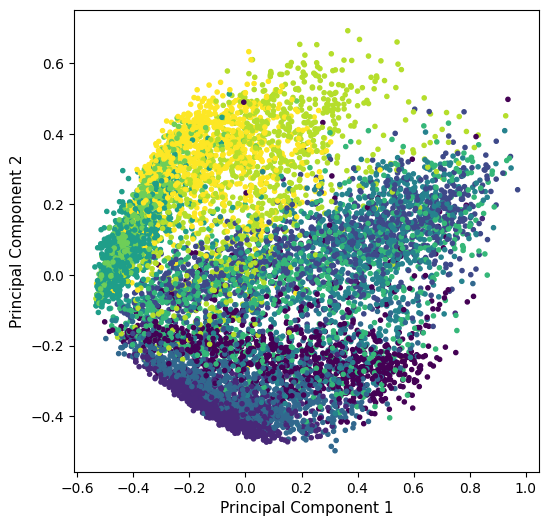

In [20]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], c = labels_train, marker='.', cmap = cmap)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# plt.savefig("Report/pca_poly_2comps.png")

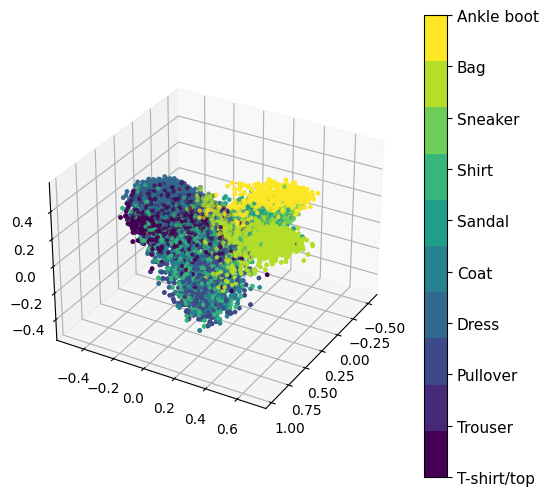

In [21]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], data_pca_poly[:, 2], c = labels_train, marker='.', cmap=cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)

ax.view_init(elev=30, azim=30)

# plt.savefig("Report/pca_poly_3comps.png")

In [22]:
# Try kernel sigmoid
kernel_pca = KernelPCA(kernel="sigmoid", n_components = 10)

data_pca_sigmoid = kernel_pca.fit_transform(train_subset_scaled)

eigenvalues_sigmoid = kernel_pca.eigenvalues_

Text(0, 0.5, 'Principal Component 2')

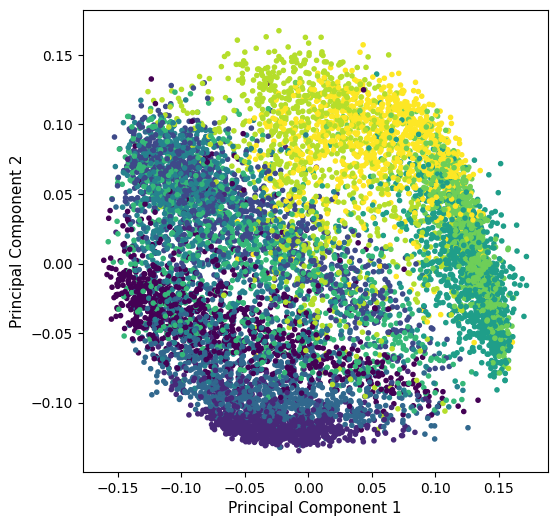

In [23]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels_train, marker='.', cmap = cmap)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# plt.savefig("Report/pca_sigmoid_2comps.png")

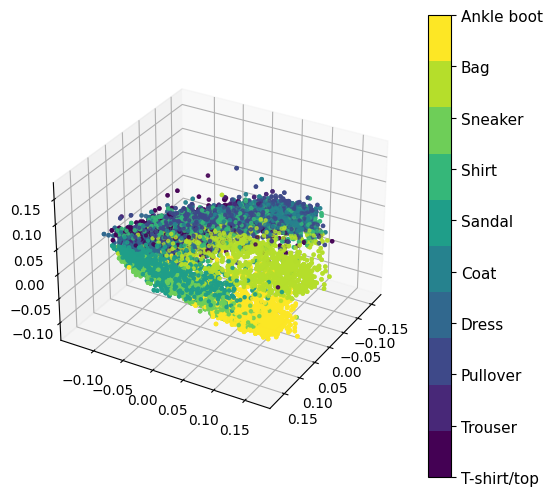

In [24]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], data_pca_sigmoid[:, 2], c = labels_train, marker='.', cmap = cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)

ax.view_init(elev=30, azim=30)

# plt.savefig("Report/pca_sigmoid_3comps.png")

In [25]:
# Measure separation of the clusters using the Davies-Bouldin score
# The lower the better

# DB_score = []

# DB_score.append(davies_bouldin_score(data_pca_linear, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_rbf, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_poly, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels_train.reshape(-1)))

# print(f"DB score: linear: {DB_score[0]:.4f} | rbf: {DB_score[1]:.4f} | poly: {DB_score[2]:.4f} | sigmoid: {DB_score[3]:.4f}")

In [26]:
del(p)
del(axs)
del(ax)
del(fig)
del(cb)

## Exercise 2

In [27]:
# Perform clustering with different techniques

labels_Kmeans = KMeans(n_clusters = 10, n_init=10).fit(data_pca_sigmoid).labels_

labels_Spectral = SpectralClustering(n_clusters = 10, affinity='nearest_neighbors').fit(data_pca_sigmoid).labels_

labels_Gaussian = GaussianMixture(n_components = 10).fit(data_pca_sigmoid).predict(data_pca_sigmoid)

labels = np.array([labels_train.reshape(subset_size), labels_Kmeans, labels_Spectral, labels_Gaussian])

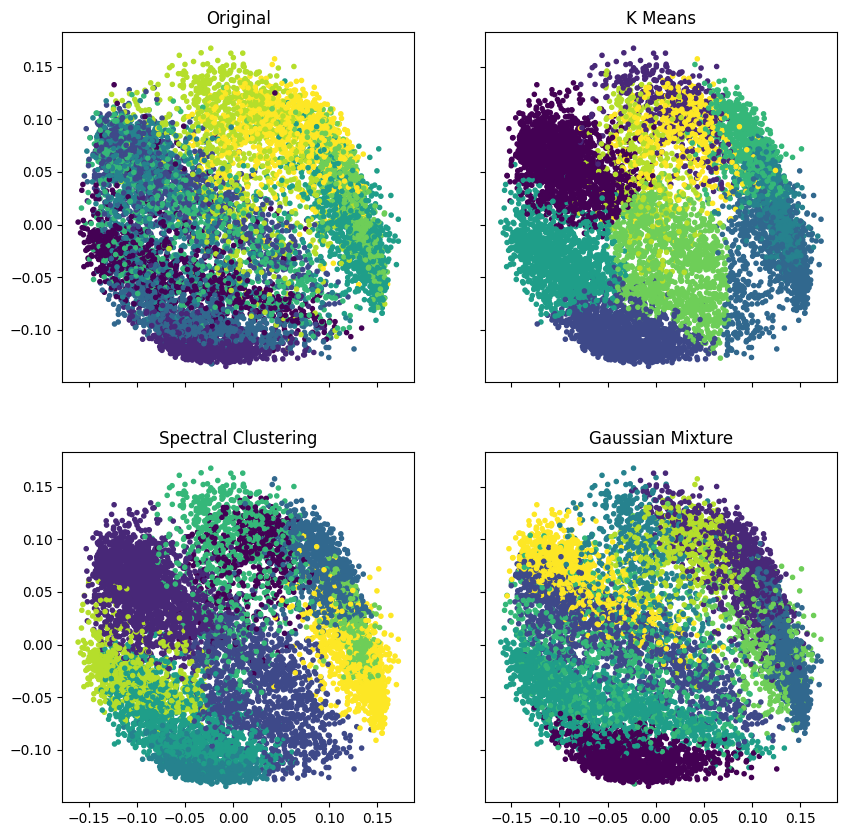

In [28]:
# Plot the results and compare them with the original clustering

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

title_names = ["Original", "K Means", "Spectral Clustering", "Gaussian Mixture"]

for ax, i in zip(axs.flat, range(4)):
    ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels[i, :], marker='.')
    ax.set_title(title_names[i])  
# plt.savefig("Report/unsupervised_clustering.png")

In [29]:
# Calculate Adjusted Rand Index

ARI = np.empty(3)

for i in range(3):
    ARI[i] = adjusted_rand_score(labels[0, :], labels[i + 1, :])
    print(f"Adjusted Rand Index for {title_names[i + 1]}: {ARI[i]:.4f}")


Adjusted Rand Index for K Means: 0.3627
Adjusted Rand Index for Spectral Clustering: 0.4340
Adjusted Rand Index for Gaussian Mixture: 0.3743


In [30]:
# Measure separation of the clusters using the Davies-Bouldin score
# The lower the better

# DB_score = []

# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[0, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[1, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[2, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[3, :].reshape(-1)))

# print(f"DB score: original: {DB_score[0]:.4f} | KMeans: {DB_score[1]:.4f} | Spectral: {DB_score[2]:.4f} | Gaussian: {DB_score[3]:.4f}")

#### a
As we can see, label assignment performed poorly. This, probably, because the clusters are very close to each other and not clearly separated.

#### b
As we can see from the plot below, there is a clear elbow on the third component. This suggests that 10 does not reflect the actual knee point of the spectrum of the principal components.

Text(0, 0.5, 'Eigenvalue')

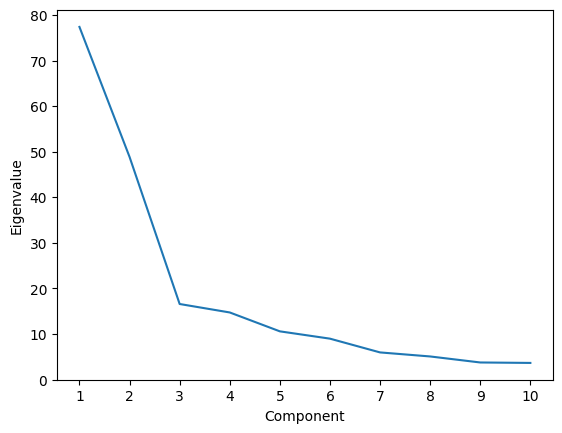

In [31]:
# Plot the eigenvalues obtained with the sigmoid method

plt.plot(np.arange(1, len(eigenvalues_sigmoid) + 1, 1), eigenvalues_sigmoid)

plt.xticks(np.arange(1, 11, 1))

plt.xlabel('Component')
plt.ylabel('Eigenvalue')

# plt.savefig("Report/eigenvalues_sigmoid.png")

In [32]:
del(ARI)
del(eigenvalues_sigmoid)
del(labels_Kmeans)
del(labels_Gaussian)
del(ax)
del(axs)
del(labels)

## Exercise 3

In [33]:
# Split the dataset into training and test set

x_train, x_test, y_train, y_test = train_test_split(train_subset_scaled, labels_Spectral, test_size=0.3, random_state=42)

#### 3.1: kernel SVM with different kernels

In [34]:
classifier = SVC(kernel="linear").fit(x_train, y_train)
label_predict_SVC_linear = classifier.predict(x_test)
acc_linear = accuracy_score(y_test, label_predict_SVC_linear)

acc_linear = accuracy_score(y_test, label_predict_SVC_linear)

In [35]:
# RBF kernel

label_predict_SVC_sigmoid = classifier.predict(x_test)
acc_sigmoid = accuracy_score(y_test, label_predict_SVC_sigmoid)

acc_sigmoid = accuracy_score(y_test, label_predict_SVC_sigmoid)

In [ ]:
classifier = SVC(kernel = "rbf").fit(x_train, y_train)

label_predict_SVC_rbf = classifier.predict(x_test)
acc_rbf = accuracy_score(y_test, label_predict_SVC_rbf)

In [36]:
# Polynomial kernel

classifier = SVC(kernel = "poly").fit(x_train, y_train)

label_predict_SVC_rbf = classifier.predict(x_test)

acc_poly = accuracy_score(y_test, label_predict_SVC_rbf)

In [37]:
# Sigmoid kernel

classifier = SVC(kernel = "sigmoid").fit(x_train, y_train)

label_predict_SVC_sigmoid = classifier.predict(x_test)

acc_sigmoid = accuracy_score(y_test, label_predict_SVC_sigmoid)

In [38]:
print(f"Accuracy: linear: {acc_linear:.4f} | rbf: {acc_rbf:.4f} | poly: {acc_poly:.4f} | sigmoid: {acc_sigmoid:.4f}")

Accuracy: linear: 0.9657 | rbf: 0.9740 | poly: 0.9617 | sigmoid: 0.3507


#### 3.2: Fully Connected NN

In [39]:
## Pass data to tensors

data_train = TensorDataset(Tensor(x_train.reshape(-1, 1, 28, 28)), th.tensor(y_train, dtype = th.long))
data_train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = False)



data_test = TensorDataset(Tensor(x_test.reshape(-1, 1, 28, 28)), th.tensor(y_test, dtype = th.long))
data_test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE, shuffle = False)

In [40]:
# Decide if you want to train muoltiple models with different hyperparameters
train_multiple_models = False

In [41]:
# Define some functions needed to calculate the accuracy

def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [42]:
# Define function used to train the model

def train_model(epochs, train_loader, criterion, optimizer, device, model):
    _batch_losses = []
    
    _model = model
    for _ in trange(epochs):
        _model = _model.train()

        # Actual (batch-wise) training step
        for _, (_images, _labels) in enumerate(train_loader):
            _images = _images.to(device)
            _labels = _labels.to(device)

            _logits = _model(_images)
            _loss = criterion(_logits, _labels)
            _batch_losses.append(_loss.item())  # Store the loss for plotting, per batch

            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()
    
    return _model

In [43]:
## Define function used to get labels
def get_predicted_labels(model, test_data, device):
    test_data_tensor = th.tensor(test_data.reshape(-1, 1, 28, 28))

    model = model.eval()

    labels = []
    with th.no_grad():
        for i in range(test_data_tensor.shape[0]):
            data = test_data_tensor[i].reshape(1, 1, 28, 28)
            pred = model(data.to(device))
            labels.append(th.argmax(pred).item())
            
    return np.array(labels)

In [44]:
# Define the Fully Connected Neural Network

class FullyConnectedNN_1layer(nn.Module):
    def __init__(self, image_dim, n_classes):
        
        super(FullyConnectedNN_1layer, self).__init__()
        
        self.fc1 = nn.Linear(in_features = image_dim,
                            out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        # x = F.relu(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [45]:
# Choose device
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [46]:
# Train the model and calculate accuracy on the test set

if train_multiple_models:
    # Choose for which epochs to train the model
    epochs = np.arange(1, 21, 1)

    # Store the accuracies and predicted labels in two arrays
    trained_acc_FC_1l = []
    labels_FC_1l = np.ndarray((3000, len(epochs)))
    
    # Choose the loss  
    criterion = nn.CrossEntropyLoss()

    # Create a vectors to store the training time (column 1) for each epoch (column 0)
    times = np.ndarray((len(epochs), 2))

    for i in epochs:
        model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10).to(device)

        optimizer = th.optim.SGD(model.parameters(), lr=0.01)
        
        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)


        model = model.train()
        
        # Keep track of how much time is required to train the model
        start_time = time.time()
        model = train_model(epochs = i,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        end_time = time.time()
        
        times[i - 1, 0] = i
        times[i - 1, 1] = end_time - start_time
        
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_FC_1l.append(trained_acc)
        
        
        labels_FC_1l[:, i - 1] = get_predicted_labels(model = model, test_data = x_test, device = device)

        print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i - 1, 1]:.2f} s")


In [47]:
# Plot the accuracy as a function of the number of epochs

if train_multiple_models:
    plt.plot(np.arange(1, len(trained_acc_FC_1l) + 1, 1), trained_acc_FC_1l)
    plt.xticks(np.arange(1, len(trained_acc_FC_1l) + 1, 2))
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex3_FCNN1l_accuracy-epochs.png")

In [80]:
# Try with two layers

class FullyConnectedNN_2layer(nn.Module):
    def __init__(self, image_dim, n_classes, hidden_features):
        
        super(FullyConnectedNN_2layer, self).__init__()
        
        self.fc1 = nn.Linear(in_features = image_dim,
                            out_features = hidden_features)
        
        self.fc2 = nn.Linear(in_features = hidden_features,
                             out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        # x = F.relu(x)
        x = self.fc2(x)
        # x = F.relu(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [49]:
# See how accuracy vary with the number of hidden neurons

if train_multiple_models:
    # Choose for which numbers of neurons to train the model
    neurons = np.arange(50, 10050, 100)

    trained_acc_FC_2l_neurons = []
    labels_FC_2l = np.ndarray((len(x_test), len(neurons)))

    times = np.ndarray((len(neurons), 2))

    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    for i in range(len(neurons)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = neurons[i])
        
        model = model.to(device)
        print(f"Using device: {device}")

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)
            
        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = 8,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        
        times[i, 0] = neurons[i]
        times[i, 1] = time.time() - start_time
        
                
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_FC_2l_neurons.append(trained_acc)
        
        print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        model = model.eval()
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device=device, model = model)

In [50]:
# Plot accuracy wrt number of neurons

if train_multiple_models:
    plt.plot(np.arange(50, 50 + 100 * len(trained_acc_FC_2l_neurons), 100), trained_acc_FC_2l_neurons)
    plt.ylim((50, 100))
    plt.xlabel("Number of hidden neurons")
    plt.ylabel("Accuracy")

    # plt.savefig("Report/ex3_FCNN2l_accuracy-neurons.png")

In [51]:
# Test how accuracy varies depending on the number of epochs

if train_multiple_models:
    # Define vector to keep all the accuracies, that we will plot
    trained_acc_FC_2l = []

    # Define an array to keep all the predicted labels
    labels_FC_2l = np.ndarray((len(x_test), len(epochs)))

    # Choose loss
    criterion = nn.CrossEntropyLoss()

    times = np.ndarray((len(epochs), 2))


    for i in range(len(epochs)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 850)
        
        model = model.to(device)
        print(f"Using device: {device}")

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
        
        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        
        times[i, 0] = epochs[i]
        times[i, 1] = time.time() - start_time
        
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_FC_2l.append(trained_acc)
        
        print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        model = model.eval()
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device=device, model = model)

In [52]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(np.arange(1, 21, 1), trained_acc_FC_2l)
    plt.xticks(np.arange(1, 21, 2))
    plt.ylim((50, 100))
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")

    # plt.savefig("Report/ex3_FCNN2l_accuracy-epochs.png")

In [82]:
# Choose one model and a set of parameter to predict the labels

times = []
test_accuracies = []

for i in range(10):
    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 4000)

    model = model.to(device)

    optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

    criterion = nn.CrossEntropyLoss()


    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    model = model.train()

    start_time = time.time()
    model = train_model(epochs = 9,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)

    elapsed_time = time.time() - start_time

    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)

    print(f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s")
    times.append(elapsed_time)
    test_accuracies.append(trained_acc)

model = model.eval()
labels_FCNN = get_predicted_labels(test_data = x_test, device=device, model = model)


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 12.5000 | Trained: 87.5000 | Time: 15.13 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 17.1875 | Trained: 87.5000 | Time: 13.96 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 10.9375 | Trained: 85.9375 | Time: 15.69 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 4.6875 | Trained: 85.9375 | Time: 17.36 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 4.6875 | Trained: 85.9375 | Time: 15.46 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 25.0000 | Trained: 87.5000 | Time: 15.14 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 23.4375 | Trained: 87.5000 | Time: 14.56 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 6.2500 | Trained: 87.5000 | Time: 14.20 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 12.5000 | Trained: 87.5000 | Time: 13.71 s


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: untrained: 9.3750 | Trained: 84.3750 | Time: 14.44 s


In [83]:
print(f"Average time: {np.mean(times):.2f} s | Max time: {np.max(times):.2f} s | Min time: {np.min(times):.2f} s")
print(f"Average accuracy: {np.mean(test_accuracies):.2f}% | Max accuracy: {np.max(test_accuracies):.2f}% | Min accuracy: {np.min(test_accuracies):.2f}%")

Average time: 14.96 s | Max time: 17.36 s | Min time: 13.71 s
Average accuracy: 86.72% | Max accuracy: 87.50% | Min accuracy: 84.38%


#### 3.3: Convolutional Neural Network

In [54]:
class CNN_1layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size):
        super(CNN_1layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = self._dimensions[1],
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(self._dimensions[1])
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        
        self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool(x)

        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        
        x = F.log_softmax(x, dim = 1)
        
        return x

In [55]:
# Train the model for different number of epochs

if train_multiple_models:
    model = CNN_1layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28])

    # Choose loss
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)
    # Define vector to keep all the accuracies, that we will plot
    trained_acc_CNN_1l = []

    epochs = [1, 10, 20]

    CNN_labels = np.ndarray((len(x_test), len(epochs)))

    times = np.ndarray((len(epochs), 2))

    for i in range(len(epochs)):

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)


        model = model.to(device)

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        
        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        
        times[i - 1, 0] = epochs[i]
        times[i - 1, 1] = time.time() - start_time
            
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        trained_acc_CNN_1l.append(trained_acc)

        model = model.eval()

        CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [56]:
# Plot the accuracy wrt the number of epochs used to train the model
if train_multiple_models:
    plt.plot(epochs, trained_acc_CNN_1l)
    plt.xticks(epochs)
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex3_CNN1l_accuracy-epochs.png")

In [57]:
# Try with two layers

class CNN_2layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size, hidden_size):
        super(CNN_2layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = hidden_size,
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(hidden_size)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool1 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self._dimensions[1], kernel_size=self._kernel)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        self.bn2 = nn.BatchNorm2d(self._dimensions[1])
        
        self.pool2 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        
        x = F.relu(x)
        
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)

        x = F.log_softmax(x, dim = 1)

        return x

In [58]:
# Train the model for different number of epochs`

if train_multiple_models:
    model = CNN_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size=100)

    criterion = nn.CrossEntropyLoss()

    trained_acc_CNN_2l = []

    CNN_labels = np.ndarray((len(x_test), len(epochs)))

    times = np.ndarray((len(epochs), 2))

    for i in range(len(epochs)):

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)


        model = model.to(device)
        print(f"Using device: {device}")

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        times[i, 0] = epochs[i]
        times[i, 1] = time.time() - start_time
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()

        CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [59]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(epochs, trained_acc_CNN_2l)
    plt.xticks(epochs)
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex3_CNN2l_accuracy-epochs.png")

In [60]:
# Train the model for different number of neurons

if train_multiple_models:
    criterion = nn.CrossEntropyLoss()

    trained_acc_CNN_2l = []

    neurons = [50, 500, 1000]

    times = np.ndarray((len(neurons), 2))

    CNN_labels = np.ndarray((len(x_test), len(neurons)))

    for i in range(len(neurons)):
        model = CNN_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size = neurons[i])
        
        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        
        model = model.to(device)
        print(f"Using device: {device}")

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

        model = model.train()
        start_time = time.time()
        model = train_model(epochs = 2,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        times[i, 0] = neurons[i]
        times[i, 1] = time.time() - start_time
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()

        CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [61]:
# Plot the accuracy wrt the number of neurons per hidden layer
if train_multiple_models:
    plt.plot(neurons, trained_acc_CNN_2l)
    plt.xticks(neurons)
    plt.xlabel('Number of neurons per hidden layer')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex3_CNN2l_accuracy-neurons.png")

In [84]:
# Choose one model and a set of parameter to predict the labels
times = []
test_accuracies = []

for i in range(10):
    model = CNN_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size = 50)

    model = model.to(device)

    optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

    criterion = nn.CrossEntropyLoss()


    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    model = model.train()

    start_time = time.time()
    model = train_model(epochs = 5,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)

    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    test_accuracies.append(trained_acc)

    print(f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s")

model = model.eval()
labels_CNN = get_predicted_labels(test_data = x_test, device=device, model = model)

  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 3.1250 | Trained: 92.1875 | Time: 48.14 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 6.2500 | Trained: 87.5000 | Time: 46.79 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 15.6250 | Trained: 93.7500 | Time: 44.47 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 7.8125 | Trained: 85.9375 | Time: 46.66 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 9.3750 | Trained: 95.3125 | Time: 55.00 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 0.0000 | Trained: 90.6250 | Time: 48.51 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 14.0625 | Trained: 90.6250 | Time: 43.69 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 4.6875 | Trained: 90.6250 | Time: 44.14 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 6.2500 | Trained: 89.0625 | Time: 40.92 s


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: untrained: 14.0625 | Trained: 90.6250 | Time: 44.89 s


In [85]:
print(f"Average time: {np.mean(times):.2f} s | Max time: {np.max(times):.2f} s | Min time: {np.min(times):.2f} s")
print(f"Average accuracy: {np.mean(test_accuracies):.2f}% | Max accuracy: {np.max(test_accuracies):.2f}% | Min accuracy: {np.min(test_accuracies):.2f}%")

Average time: 46.32 s | Max time: 55.00 s | Min time: 40.92 s
Average accuracy: 90.62% | Max accuracy: 95.31% | Min accuracy: 85.94%


In [86]:
# Define a 2-layer Fully Convolutional Network

class FullyConv_2layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size, hidden_size):
        super(FullyConv_2layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = hidden_size,
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(hidden_size)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool1 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self._dimensions[1], kernel_size=self._kernel)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        self.bn2 = nn.BatchNorm2d(self._dimensions[1])
        
        self.pool2 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
    
        
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        
        x = F.relu(x)
        
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)

        x = F.log_softmax(x, dim = 1)

        return x

In [92]:
model = FullyConv_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size = 250)

optimizer = th.optim.SGD(model.parameters(), lr = 0.01)


model = model.to(device)
print(f"Using device: {device}")

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

model = model.train()
start_time = time.time()
model = train_model(epochs = 2,
                    train_loader = data_train_loader,
                    criterion = criterion,
                    optimizer = optimizer,
                    device = device,
                    model = model)
elapsed_time = time.time() - start_time
model = model.eval()

trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
print(f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s")

Using device: cpu
Untrained test loss: 6.1823, accuracy: 9.38%


  0%|          | 0/2 [00:00<?, ?it/s]

Accuracy: untrained: 9.3750 | Trained: 4.6875 | Time: 81.17 s


### Section 4

In [69]:
print(train_subset_scaled.shape)
print(data_pca_sigmoid.shape)
print(label_predict_SVC_linear.shape)
print(label_predict_SVC_sigmoid.shape)
print(label_predict_SVC_rbf.shape)
print(labels_FCNN.shape)
print(labels_CNN.shape)

(10000, 784)
(10000, 10)
(3000,)
(3000,)
(3000,)
(3000,)
(3000,)


In [70]:
# Gets 30 samples for the specified class according to given labels


def show_class(class_number, labels):
    indeces = []
    for i in range(30):
        while labels[i] != class_number:
            i = np.random.choice(len(labels), size=1, replace=False)[0]
        indeces.append(i)

    fig, axs = plt.subplots(5, 6, figsize=(5, 3))
    axs = axs.flatten()

    for i, idx in enumerate(indeces):
        axs[i].imshow(
            train_subset_scaled[idx].reshape(28, 28), cmap="gray"
        )  # Assuming images are 28x28 pixels
        axs[i].axis("off")  # Turn off axis labels for cleaner visualization
    plt.tight_layout()
    plt.show()

In [71]:
print(set(labels_FCNN))
print(set(labels_CNN))
print(set(label_predict_SVC_rbf))
print(set(label_predict_SVC_linear))
print(set(label_predict_SVC_sigmoid))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 9}


Showing class 0:


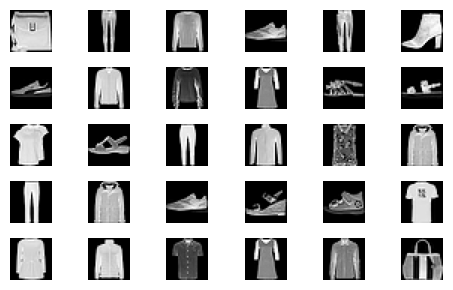

Showing class 1:


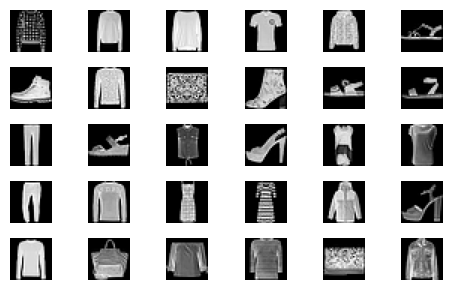

Showing class 2:


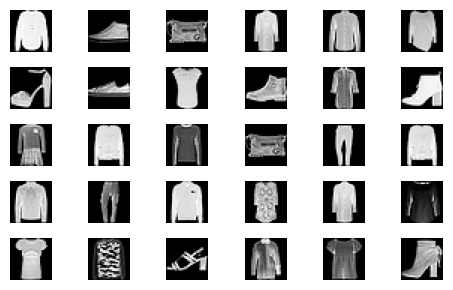

Showing class 3:


KeyboardInterrupt: 

In [72]:
for i in range(10):
    print("Showing class " + str(i) + ":")
    show_class(i, labels_CNN)

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [ ]:
# Split train and test dataset as before, but this time use the true labels

x_train, x_test, y_train, y_test = train_test_split(train_subset_scaled, labels_train, test_size = 0.3, random_state = 42)

In [ ]:
classifier = SVC(kernel = "linear").fit(x_train, y_train.reshape(len(y_train)))

label_predict = classifier.predict(x_test)
accuracy_score(y_test, label_predict)

0.826

In [ ]:
classifier = SVC(kernel = "rbf").fit(x_train, y_train.reshape(len(y_train)))

label_predict = classifier.predict(x_test)
accuracy_score(y_test, label_predict)

0.856

In [ ]:
classifier = SVC(kernel = "poly").fit(x_train, y_train.reshape(len(y_train)))

label_predict = classifier.predict(x_test)
accuracy_score(y_test, label_predict)

0.823

In [ ]:
classifier = SVC(kernel = "sigmoid").fit(x_train, y_train.reshape(len(y_train)))

label_predict = classifier.predict(x_test)
accuracy_score(y_test, label_predict)

0.37633333333333335

#### 5.2: Fully Connected NN
Trying different numbers of layers and hidden features

In [ ]:
data_train = TensorDataset(Tensor(x_train.reshape(-1, 1, 28, 28)), th.tensor(y_train.reshape(len(y_train)), dtype = th.long))
data_train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = False)

data_test = TensorDataset(Tensor(x_test.reshape(-1, 1, 28, 28)), th.tensor(y_test.reshape(len(y_test)), dtype = th.long))
data_test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

### 5.2
Fully Connected Neural Network

In [ ]:
# Train the Fully Connected Neural Network with 1 layer and calculate accuracy on the test set for different number of epochs

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

    model = model.eval()

    model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10).to(device)


    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    epochs = np.arange(1, 21, 1)

    trained_acc_FC_1l = []
    labels_FC_1l = np.ndarray((len(x_test), len(epochs)))

    for i in range(len(epochs)):
        
        model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10).to(device)

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        
        model = model.train()

        model = train_model(epochs = epochs[i],
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_1l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_1l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(epochs, trained_acc_FC_1l)
    plt.xticks(epochs[::2])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_FCNN1l_accuracy-epochs.png")

In [ ]:
# Train the Fully Connected Neural Network with 2 layers and calculate accuracy on the test set for different number of epochs

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

    model = model.eval()

    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features=250).to(device)


    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    trained_acc_FC_2l = []
    labels_FC_2l = np.ndarray((len(x_test), len(epochs)))

    for i in range(len(epochs)):
        
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features=250).to(device)

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        
        model = model.train()

        model = train_model(epochs = epochs[i],
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_2l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(epochs, trained_acc_FC_2l)
    plt.xticks(epochs[::2])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_FCNN2l_accuracy-epochs.png")

In [ ]:
# Train the Convolutional Neural Network with 2 layers and calculate accuracy on the test set for different number of neurons

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    neurons = np.arange(50, 10050, 100)

    labels_FC_2l = np.ndarray((len(x_test), len(neurons)))
    trained_acc_FC_2l = []


    for i in range(len(neurons)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = neurons[i]).to(device)
        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
        
        model = model.train()

        model = train_model(epochs = 2,
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_2l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

    # print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")

In [ ]:
# Plot the accuracy wrt the number of neurons

if train_multiple_models:
    plt.plot(neurons, trained_acc_FC_2l)
    plt.xlabel("Number neurons per hidden layer")
    plt.ylabel("Trained accuracy")
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_FCNN2l_accuracy-neurons.png")

In [ ]:
# Choose one model and a set of parameter to predict the labels

# Choose the loss
criterion = nn.CrossEntropyLoss()

model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 6000).to(device)
optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

model = model.train()

model = train_model(epochs = 10,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)
model = model.eval()
        
trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)

print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

labels_FC_2l = get_predicted_labels(test_data = x_test, device = device, model = model)

Untrained test loss: 2.3173, accuracy: 10.94%


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 87.5 | Loss: 0.3979659080505371


#### 5.3:
Convolutional and Fully Convolutional Neural Network

In [ ]:
train_multiple_models = True

In [ ]:
# Train the Convolutional Neural Network with 1 layer and calculate accuracy on the test set for different number of epochs

if train_multiple_models:
    # Device selection
    
    epochs = np.arange(1, 21, 1)
    
    trained_acc_CNN_1l = []
    labels_CNN_1l = np.ndarray((len(x_test), len(epochs)))
    
    for i in range(len(epochs)):
        model = CNN_1layer(n_classes = 10, kernel_size = 3, input_size = [7000, 1, 28, 28])

        criterion = nn.CrossEntropyLoss()

        # optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)
        optimizer = optim.SGD(model.parameters(), lr = 0.01)

        

        model = model.to(device)

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        
        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

        model = model.train()

        model = train_model(epochs = epochs[i],
                                    train_loader = data_train_loader,
                                    criterion = criterion,
                                    optimizer = optimizer,
                                    device = device,
                                    model = model)
        model = model.eval()
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_CNN_1l.append(trained_acc)
        
        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

        labels_CNN_1l[:, i] = get_predicted_labels(test_data= x_test, model = model, device = device)

Untrained test loss: 2.3038, accuracy: 9.38%


  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.25 | Loss: 0.5710183382034302
Untrained test loss: 2.3066, accuracy: 3.12%


  0%|          | 0/2 [00:00<?, ?it/s]

Accuracy: 82.8125 | Loss: 0.7305908799171448
Untrained test loss: 2.3625, accuracy: 1.56%


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: 84.375 | Loss: 0.5940471291542053
Untrained test loss: 2.3251, accuracy: 6.25%


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy: 82.8125 | Loss: 0.5983549356460571
Untrained test loss: 2.2954, accuracy: 15.62%


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

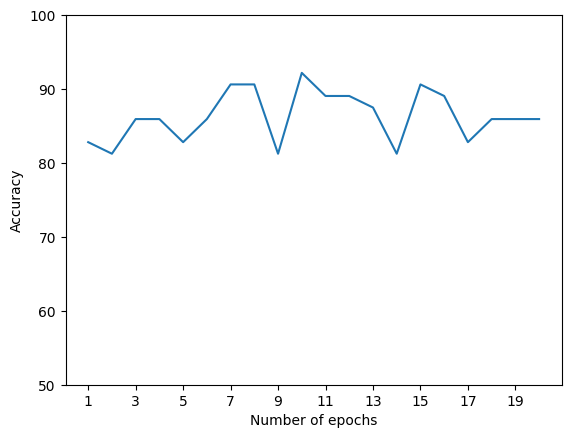

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model
if train_multiple_models:
    plt.plot(epochs, np.array(trained_acc_CNN_1l))
    plt.xticks(epochs[::2])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_CNN1l_accuracy-epochs.png")

In [ ]:
# Train the Convolutional Neural Network with 2 layers and calculate accuracy on the test set for different number of neurons per hidden layer
if train_multiple_models:
    
    neurons = np.arange(50, 550, 100)
    
    labels_CNN_2l = np.ndarray((len(x_test), len(neurons)))
    
    trained_acc_CNN_2l = []
    
    for i in range(len(neurons)):
        model = CNN_2layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28], hidden_size = neurons[i])

        criterion = nn.CrossEntropyLoss()

        optimizer = th.optim.SGD(model.parameters(), lr=0.01)

        model = model.to(device)

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)


        model = model.train()

        start_time = time.time()
        model = train_model(epochs = 3,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)

        model = model.eval()
        times = time.time() - start_time
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Neurons: {neurons[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()
        labels_CNN_2l[:, i] = get_predicted_labels(test_data = x_test, model = model, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Neurons: 50 | Accuracy: untrained: 7.8125 | Trained: 89.0625 | Time: 45.84 s


  0%|          | 0/3 [00:00<?, ?it/s]

Neurons: 150 | Accuracy: untrained: 3.1250 | Trained: 78.1250 | Time: 126.01 s


  0%|          | 0/3 [00:00<?, ?it/s]

Neurons: 250 | Accuracy: untrained: 14.0625 | Trained: 85.9375 | Time: 168.66 s


  0%|          | 0/3 [00:00<?, ?it/s]

Neurons: 350 | Accuracy: untrained: 9.3750 | Trained: 84.3750 | Time: 274.63 s


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Plot the accuracy wrt the number of neurons per hidden layer

if train_multiple_models:
    plt.plot(neurons, trained_acc_CNN_2l)
    plt.xlabel("Number neurons per hidden layer")
    plt.ylabel("Trained accuracy")
    plt.ylim(50, 100)
    plt.savefig("Report/ex5_CNN2l_accuracy-neurons.png")

In [ ]:
# Choose one set of parameters

model = CNN_2layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28], hidden_size = 200)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)


model = model.to(device)

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

model = model.train()

model = train_model(epochs = 3,
                    train_loader = data_train_loader,
                    criterion = criterion,
                    optimizer = optimizer,
                    device = device,
                    model = model)

model = model.eval()
trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

model = model.eval()
labels_CNN_2l = get_predicted_labels(test_data = x_test, model = model, device = device)